# Objetivo.

Determinar computacionalmente que distribucion siguen el TPA


In [2]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd

%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
import seaborn as sns
import os
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro 
#to en otra carpeta
sns.set_theme()

# Funciones base utilizadas a lo largo del codigo:



In [2]:
# Función ajustar
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
    señal_ruido=[ np.random.normal(señal[i], señal[i]*desv) for i in range(0,len(señal))]
    return np.array(señal_ruido)

def central(s,k):

    '''
    Funcion para verificar teorema del limite central

    Parametros
    -----------
    s: Arreglo
     Arreglo de datos a los que se quieren aplicar el teorema
    k: float
     Numero de datos para efectuar el promedio

'''

    new_s=[]

    for i in range(0,len(s)):
        new_s.append(np.mean(np.random.choice(s,size=k)))
    return new_s

def confirm_gauss(s):
    result = (anderson(np.sort(s), dist='norm'))
    criterio=((result[0]<result[1][3])or(shapiro(np.sort(s))[1]>0.05))*1   
    return criterio
    


En este notebook se estudia de forma sistematica, el ajuste del fenomeno de absorción de dos fotones bajo las dos perspectivas presentadas en el articulo.


# 1) Perspectiva 1.
En esta perspectiva se cuenta con la siguiente ecuación que da el parametro físico de interes:

$$\beta=\left[\frac{1}{2\sqrt{2}} \frac{(1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \right]^{-1}\left[1-T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})\right] \hspace{2 mm} (1)$$

A continuación fijamos los parametros del experimento que asumiremos como reales:

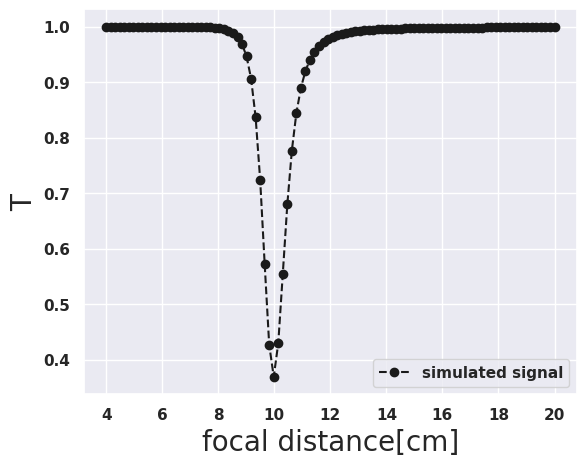

In [3]:
fig=plt.figure(figsize=(14,5))

######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=1e-2*np.linspace(4,20,100)#focal distance [m]
beta = 500e-11 # TPA seed in (m/W )
L= 0.70e-3 # thickness in (m).
Pavg = 95e-3# Average power in (W)
Tp = 2e-9 # pulse width FWHM in (s)
wl = 1063.5e-9 #central wavelength in (m)
D = 1.5e-3 # beam diameter in (m)
ds = 100e-3# Distance EFTL-sample (m)a
Cf = 1.1 # beam correction coeff
alfa = 975 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 11e3 #Frecuencia en HZ


T=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
val_min=min(T)
index=T.index(min(T))
#Td= np.gradient(T)
#Pavg=Pavg+0.05*Pavg
#L=L+0.05*L
#ds=ds+0.05*ds7
plt.subplot(122)
plt.plot(focal*100,T,'--ko',label='simulated signal')
#plt.plot(corriente,Td,'--ro',label='derivada')
plt.ylabel('T',fontsize=20)
plt.xlabel('focal distance[cm]',fontsize=20)
plt.legend()



In [4]:
def dist_betas(N,desv,k): 
  '''

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]
  TT=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
  trans=TT[k] #Minimo de la señal simulada. 
  f=focal[k]  #Distancia focal correspondiente al minimo.   
  for ii in range(N):
      
      er=desv/100
      er_L=er
      er_P=er
      er_T=er
      er_wl=er
      er_D=er
      er_ds=er
      er_Cf=er
      er_a=er
      er_R=er
      er_freq=er
      er_trans=er
      er_focal=er
      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
      D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
      ds_f = np.random.normal(ds,ds*er_ds,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
      R_f = np.random.normal(R,R*er_R,1) # Reflectance
      freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance
      trans_f= np.random.normal(trans,trans*er_trans,1)
      focal_f=np.random.normal(f,f*er_focal,1)
      
      TPA.append(BETA(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)[0]*1e11)
      
    
  return TPA

# Ejemplo:

Como ejemplo ilustrativo de lo que se hara luego, se considera la distribución de betas de acuerdo a la función previamente definida para un error relativo dado. Se confirma si la distribución obtenida sigue o no una distribución gaussiana. Además se le aplica el teorema del limite central.

Criterio de gaussianidad:  1


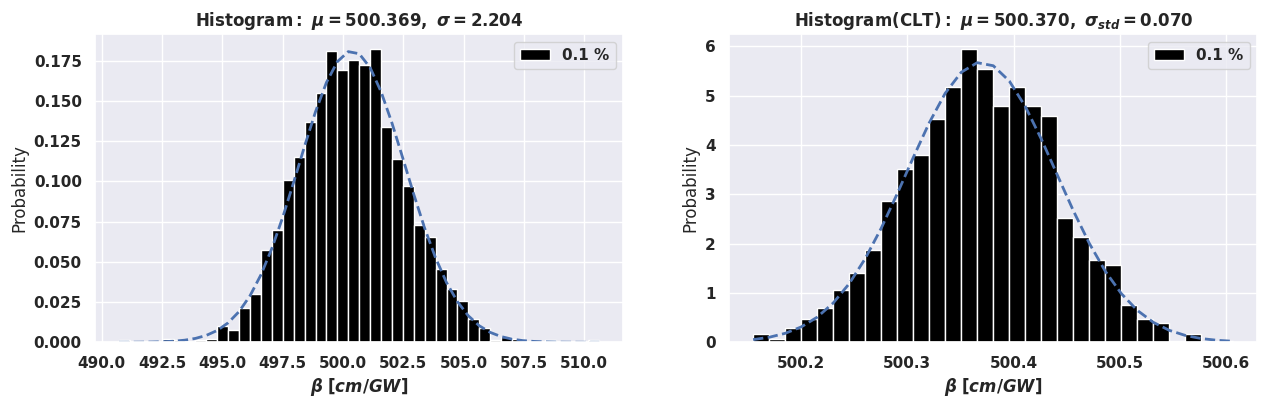

In [8]:
f=plt.figure(figsize=(15,4))

plt.subplot(121)
er_r=0.1
beta_hist=np.array(dist_betas(2000,er_r,index))
print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='black',label=str(er_r)+' %')
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'b--', linewidth=2)
plt.ylabel('Probability')
plt.xlabel(r'$\beta$ $[cm/GW]$')
plt.title(r'$\mathrm{Histogram:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()


plt.subplot(122)

beta_hist=central(beta_hist,1000)
error=(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),1))
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='black',label=str(er_r)+' %')

# add a 'best fit' line
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'b--', linewidth=2)
plt.ylabel('Probability')
plt.xlabel(r'$\beta$ $[cm/GW]$')
plt.title(r'$\mathrm{Histogram(CLT):}\ \mu=%.3f,\ \sigma_{std}=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()







Nuestro proposito a continuación es verificar en general para que valores de error la distribución de betas sigue una distribucion gaussiana. En general existen diferentes valores de corriente que se pueden seleccionar para realizar el calculo de beta y por tanto obtener una distribucion. Por tanto, se deben verificar todos los valores dentro del rango ya definido (0,300) mA.

In [9]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,5,50) #Porcentaje de error
final=np.zeros((len(er_r),len(focal)))

for k in range(len(focal)):

    for c,j in enumerate(er_r):

        beta_hist=np.array(dist_betas(1000,j,k))
        criterio=confirm_gauss(beta_hist)
        final[c,k]=criterio
        

([<matplotlib.axis.YTick at 0x7f521c08e140>,
 [Text(0, 0, '0.005'),
  Text(0, 8, '0.821'),
  Text(0, 16, '1.636'),
  Text(0, 24, '2.452'),
  Text(0, 32, '3.267'),
  Text(0, 40, '4.083'),
  Text(0, 48, '4.898')])

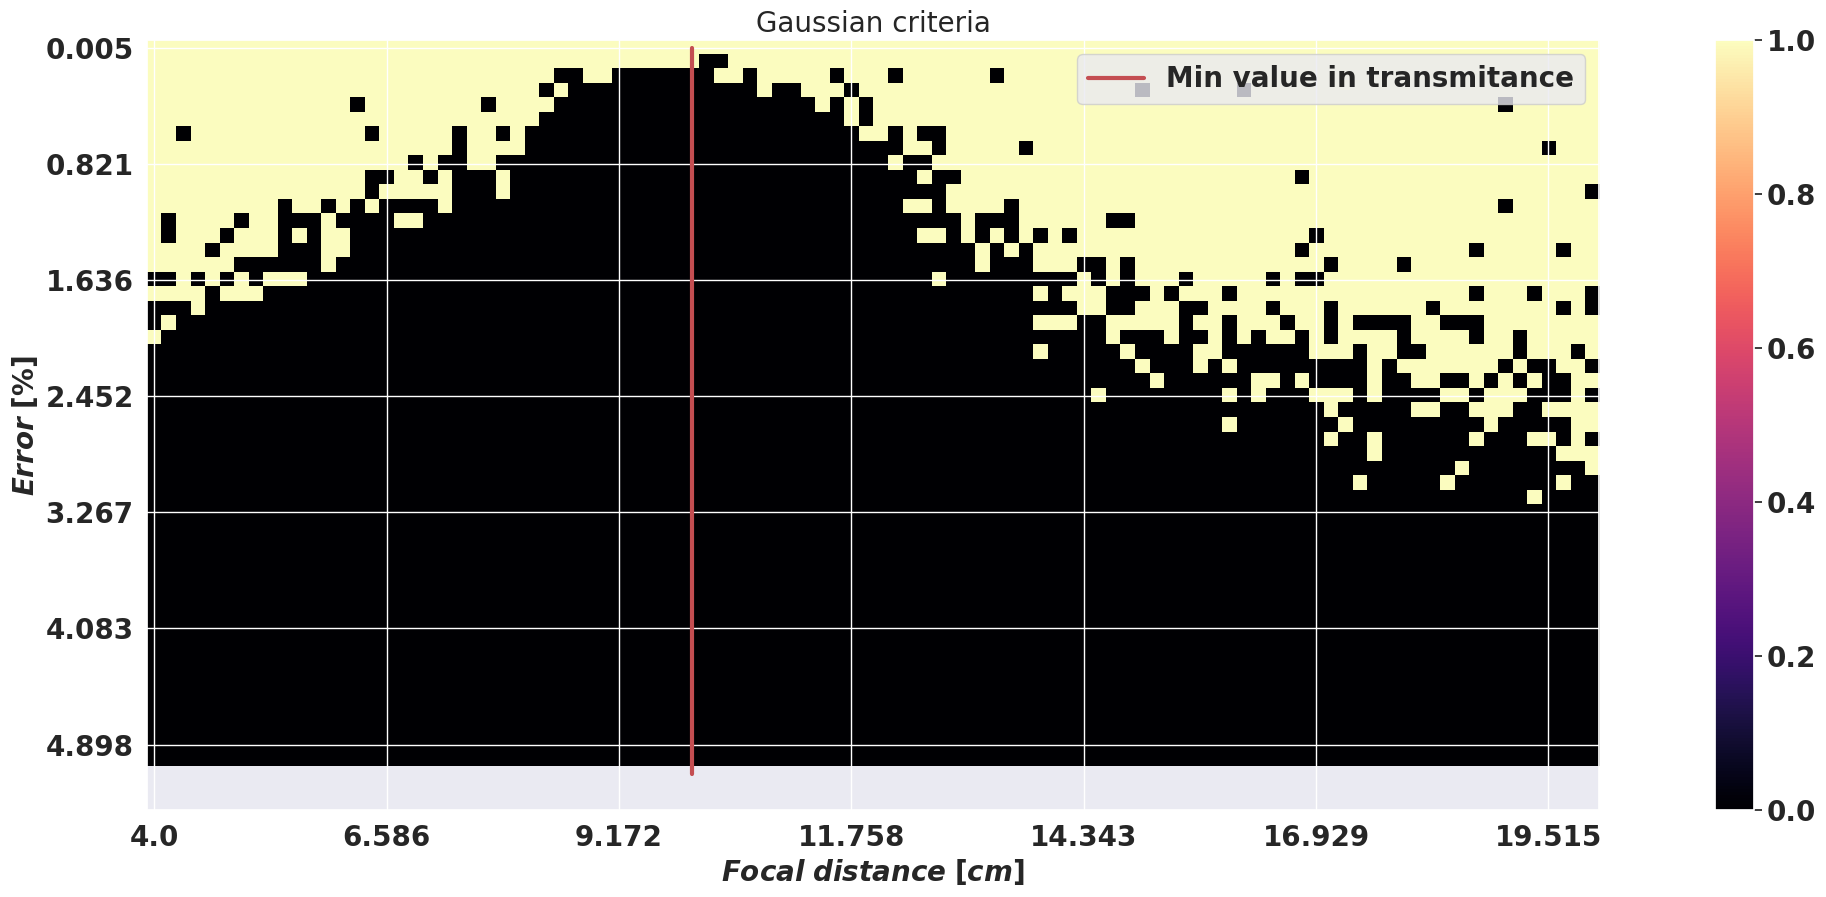

In [10]:
fig = plt.figure(figsize=(30,10))

er_r=np.linspace(0.005,5,50) #Porcentaje de error
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.imshow(final, cmap='magma')
plt.plot([index,index],[len(er_r),0],'r',lw=3,label='Min value in transmitance')
plt.ylabel('$Error$ $[\%]$',fontsize=20)
plt.xlabel('$Focal$ $distance$ $[cm]$',fontsize=20)
plt.title('Gaussian criteria',fontsize=20)
plt.legend(fontsize=20)
plt.colorbar()

nx = focal.shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = np.round(100*focal[::step_x],3) # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)

ny = er_r.shape[0]
no_labels = 7 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],3) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)


El grafico anterior muestra que en general la distribución de betas no sera Gaussiana. Sin embargo, para errores pequeños, en las cercanias del valor de distancia focal que corresponde al minimo de transmitancia, se puede decir que la distribución de betas es Gaussiana.

Se debe resaltar algo importante de lo anterior: este resultado fue obtenido simulando los parametros con generadores de números aleatorios gaussianos con media en el valor real. Sin embargo, esto no es conveniente, ya que en una situación real nuestra media de los parametros que medimos no coincide con el valor real del parametro físico. Por tanto a continuación se realizara el mismo grafico añadiendo un error del 1% a las medias de las distribuciones.

In [11]:
beta = 500e-11 # TPA seed in (m/W )
L= 0.70e-3 # thickness in (m).
Pavg = 95e-3# Average power in (W)
Tp = 2e-9 # pulse width FWHM in (s)
wl = 1063.5e-9 #central wavelength in (m)
D = 1.5e-3 # beam diameter in (m)
ds = 100e-3# Distance EFTL-sample (m)a
Cf = 1.1 # beam correction coeff
alfa = 975 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 11e3 #Frecuencia en HZ

In [12]:
# Parametros que se asumen reales
er2=1/100
beta2 = beta+beta*er2 # TPA seed in (m/W )
L2= L+L*er2 # thickness in (m).
Pavg2 = Pavg+Pavg*er2# Average power in (W)
Tp2 = Tp+Tp*er2 # pulse width FWHM in (s)
wl2 = wl+wl*er2 #central wavelength in (m)
D2 = D+D*er2# beam diameter in (m)
ds2 = ds+ds*er2# Distance EFTL-sample (m)a
Cf2 = Cf+Cf*er2 # beam correction coeff
alfa2 = alfa+alfa*er2 # linear absorption in (1/m) 
R2 =R+R*er2 # reflection percentage 
freq2 = freq+freq*er2 #Frecuencia en HZ


def dist_betas(N,desv,k): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]
  TT=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
  trans=TT[k] #Minimo de la señal simulada. 
  f=focal[k]  #Distancia focal correspondiente al minimo.   
  trans2=TT[k]+TT[k]*er2 #Minimo de la señal simulada. 
  f2=focal[k]+focal[k]*er2  #Distancia focal correspondiente al minimo.   
  for ii in range(N):
      
      er=desv/100
      er_L=er
      er_P=er
      er_T=er
      er_wl=er
      er_D=er
      er_ds=er
      er_Cf=er
      er_a=er
      er_R=er
      er_freq=er
      er_trans=er
      er_focal=er
      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L2,L*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg2,Pavg*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp2,Tp*er_T,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl2,wl*er_wl,1) #central wavelength in (m)
      D_f = np.random.normal(D2,D*er_D,1) # beam diameter in (m)
      ds_f = np.random.normal(ds2,ds*er_ds,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf2,Cf*er_Cf,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa2,alfa*er_a,1)) #linear absorption (1/m)
      R_f = np.random.normal(R2,R*er_R,1) # Reflectance
      freq_f = np.random.normal(freq2,freq*er_freq,1) # Reflectance
      trans_f= np.random.normal(trans2,trans*er_trans,1)
      focal_f=np.random.normal(f2,f*er_focal,1)
      
      TPA.append(round(BETA(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)[0]*1e11))
      
    
  return TPA

In [13]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,5,50) #Porcentaje de erro
final=np.zeros((len(er_r),len(focal)))

for k in range(len(focal)):

    for c,j in enumerate(er_r):

    
        beta_hist=np.array(dist_betas(1000,j,k))
        criterio=confirm_gauss(beta_hist)
        final[c,k]=criterio
        

/usr/lib/python3/dist-packages/scipy/stats/_morestats.py:1864: RuntimeWarning: invalid value encountered in divide
  w = (y - xbar) / s
/usr/lib/python3/dist-packages/scipy/stats/_morestats.py:1758: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


([<matplotlib.axis.YTick at 0x7f521c0ef010>,
 [Text(0, 0, '0.005'),
  Text(0, 8, '0.821'),
  Text(0, 16, '1.636'),
  Text(0, 24, '2.452'),
  Text(0, 32, '3.267'),
  Text(0, 40, '4.083'),
  Text(0, 48, '4.898')])

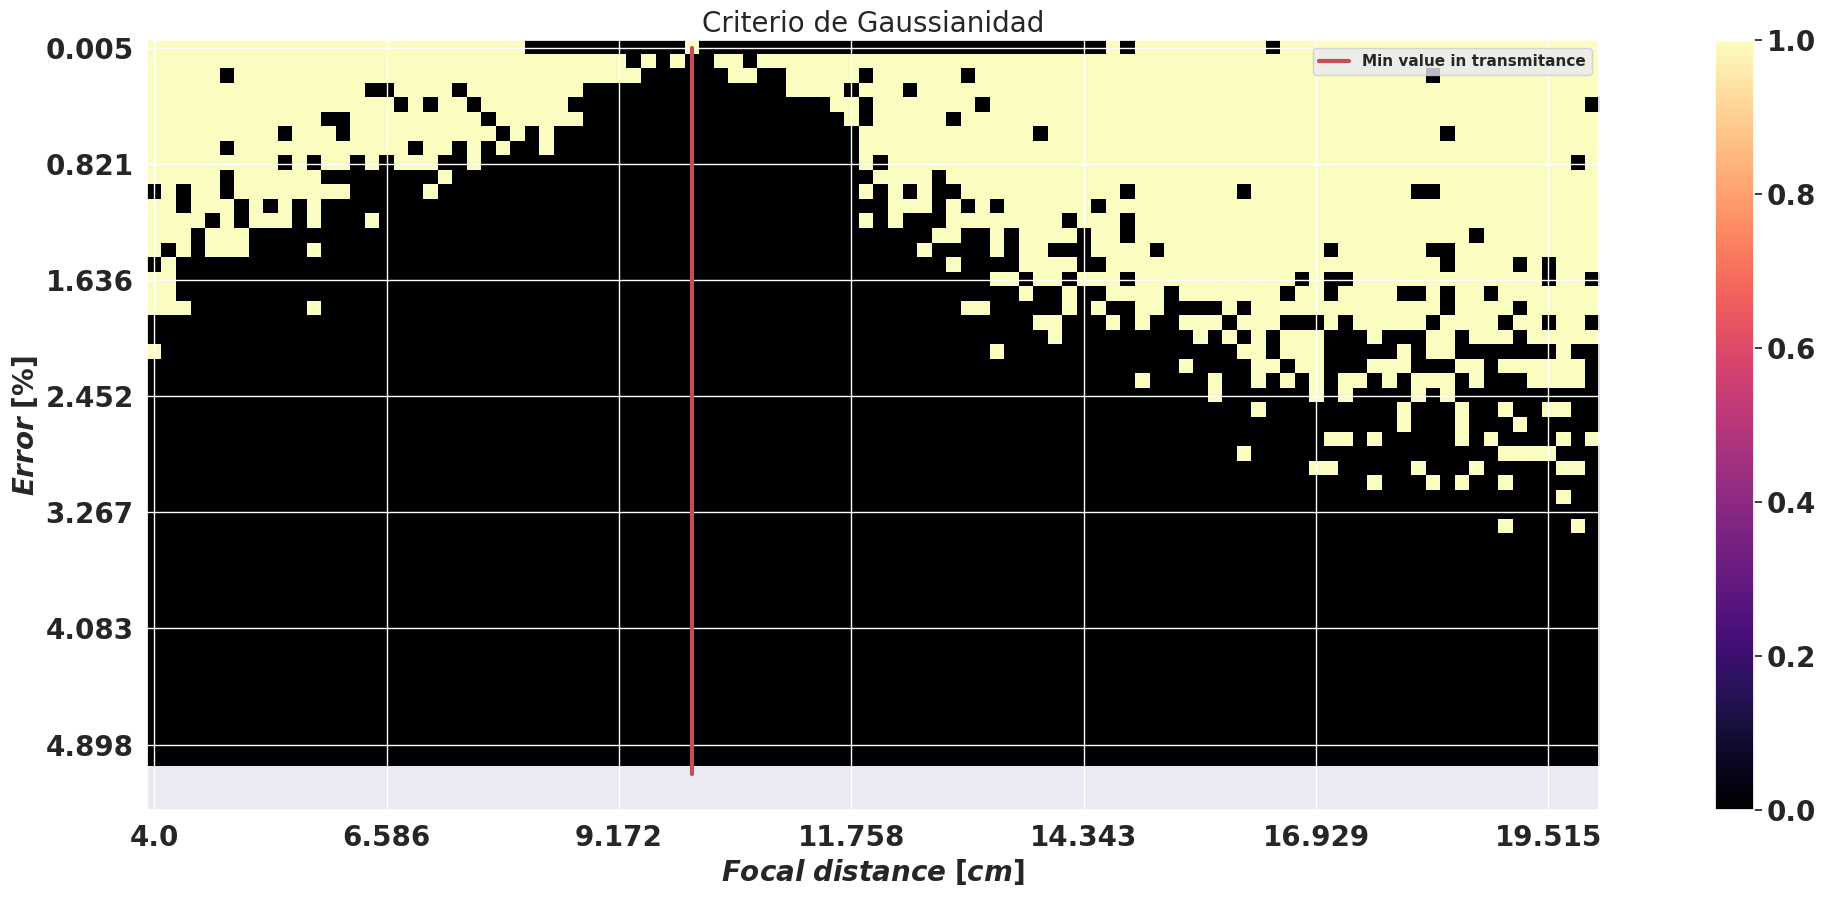

In [14]:
fig = plt.figure(figsize=(30,10))

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.imshow(final, cmap='magma')
plt.plot([index,index],[len(er_r),0],'r',lw=3,label='Min value in transmitance')
plt.ylabel('$Error$ $[\%]$',fontsize=20)
plt.xlabel('$Focal$ $distance$ $[cm]$',fontsize=20)
plt.title('Criterio de Gaussianidad',fontsize=20)
plt.legend()
plt.colorbar()

nx = focal.shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = np.round(100*focal[::step_x],3) # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)

ny = er_r.shape[0]
no_labels = 7 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],3) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)

# Perspectiva 2.

El método de obtención del parametro físico es hecho mediante una regresión a la ecuación:

$$T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})=1-\frac{1}{2\sqrt{2}} \frac{\beta (1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \hspace{2 mm} (2)$$

De la teoria se tiene que $g(x,\beta;\{v_i\})=\beta r(x;\{v_i\})+h(x;\{v_i\})$, en nuestro caso $$h(x;\{v_i\})=1$$ 
$$ r(x;\{v_i\})=-\frac{1}{2\sqrt{2}} \frac{(1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}}$$

Por tanto,

$$\beta=\frac{\sum_{l=1}^{n}r(x_l;\{ v_{i}\}) \left[y_l-h(x_l;\{ v_{i}\})\right]}{\sum_{l=1}^{n}r^{2}(x_l;\{ v_{i}\})}. \hspace{2 mm} (3) $$

In [5]:
# Función ajustar
def BETA2(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    h=1
    r=-1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    b=sum(r[i]*(trans[i]-h) for i in range(len(trans)))/sum(r[i]**2 for i in range(len(trans)))
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def dist_betas2(N,desv): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]
  
  for ii in range(N):
      
      TT=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
      er=desv/100
      trans_f=ruido(TT,er) #Minimo de la señal simulada. 
      focal_f=ruido(focal,er)  #Distancia focal correspondiente al minimo.   
      er_L=er
      er_P=er
      er_T=er
      er_wl=er
      er_D=er
      er_ds=er
      er_Cf=er
      er_a=er
      er_R=er
      er_freq=er
      er_trans=er
      er_focal=er
      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
      D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
      ds_f = np.random.normal(ds,ds*er_ds,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
      R_f = np.random.normal(R,R*er_R,1) # Reflectance
      freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance
      
      
      TPA.append(BETA2(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)*1e11)
      
    
  return TPA


# Ejemplo

Criterio de gaussianidad:  1


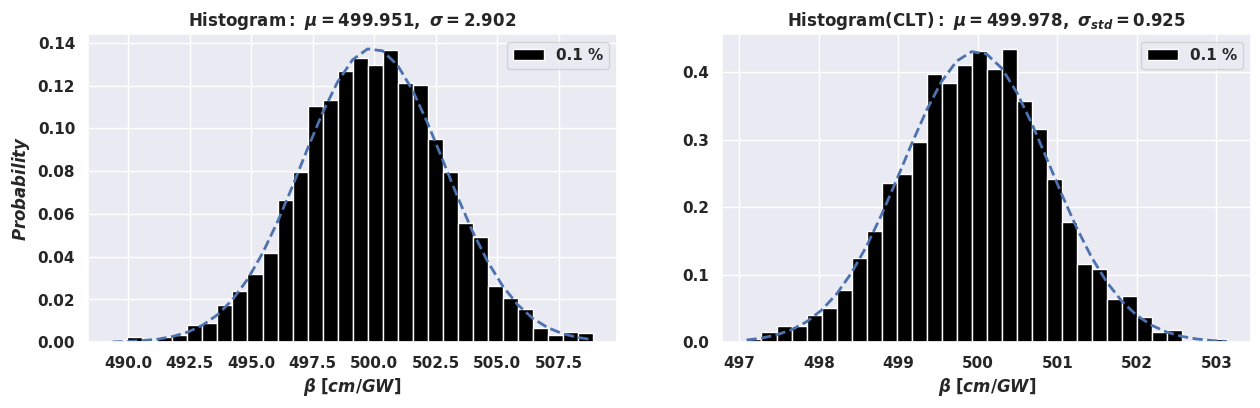

In [6]:
f=plt.figure(figsize=(15,4))


plt.subplot(121)
er_r=0.1
beta_hist=np.array(dist_betas2(2000,er_r))
print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='black',label=str(er_r)+' %')
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'b--', linewidth=2)
plt.ylabel('$Probability$')
plt.xlabel(r'$\beta$ $[cm/GW]$')
plt.title(r'$\mathrm{Histogram:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()


plt.subplot(122)
error=(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),1))
beta_hist=central(beta_hist,10)
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='black',label=str(er_r)+' %')

# add a 'best fit' line
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'b--', linewidth=2)

plt.xlabel(r'$\beta$ $[cm/GW]$')
plt.title(r'$\mathrm{Histogram(CLT):}\ \mu=%.3f,\ \sigma_{std}=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()






# Generalización:

In [7]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,5,50) #Porcentaje de error
decis=[]

for j in er_r:
    
    beta_hist=np.array(dist_betas2(1000,j))
    criterio=confirm_gauss(beta_hist)
    decis.append(criterio)
        

([<matplotlib.axis.XTick at 0x7f948840df00>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

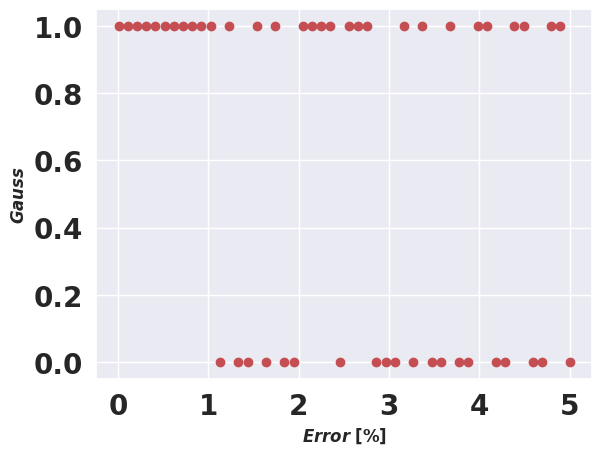

In [78]:
plt.plot(er_r,decis,'ro')
plt.xlabel('$Error$ $[\%]$')
plt.ylabel('$Gauss$')
plt.xticks([0,1,2,3,4,5],fontsize=20)

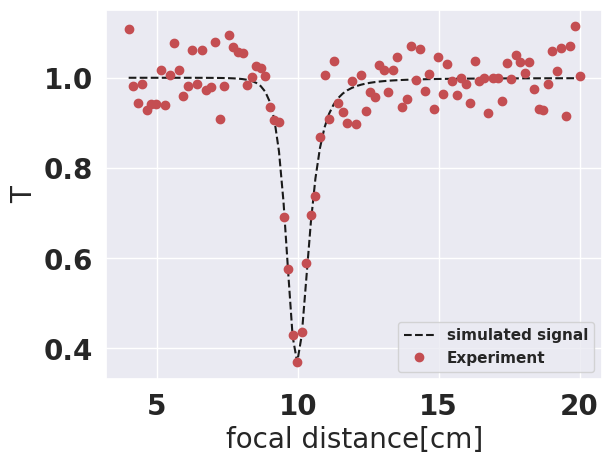

In [74]:
plt.plot(focal*100,T,'--k',label='simulated signal')
plt.plot(focal*100,ruido(T,0.05),'ro',label='Experiment')
#plt.plot(corriente,Td,'--ro',label='derivada')
plt.ylabel('T',fontsize=20)
plt.xlabel('focal distance[cm]',fontsize=20)
plt.legend()

# Conclusiones.